In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df = pd.read_excel("/content/dataset_YEMINEDERIMSON.xlsx")
df = pd.read_excel("/content/a.xlsx")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# --- 1. Risk Skoru Hesapla ---
scaler = MinMaxScaler()
features = ["Kalite", "TopMtFark", "DurusOrani", "Sure"]
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

df["risk_skoru"] = (
    0.06063633501293428 * df_scaled["DurusOrani"]
    + 0.021736108231210194 * df_scaled["Kalite"]
    + 0.4993117318517015 * df_scaled['TopMtFark']
    + 0.418315824904154 * df_scaled['Sure']
)

# --- 2. X ve y Seç ---
X_features = [
    "DesenNo", "Konstruksiyon", "UrunSinifi", "TopPozisyon", "Devir",
    "KullanimYeri", "IplikNumara", "NumaraTipi", "IplikKarisim",
    "BukumSayisi", "FilamentSayisi", "HataAdi", "TezgahAdi__TezgahNo", "En", "KKTopMt"
]
X = pd.get_dummies(df[X_features], drop_first=True)
y = df["risk_skoru"]

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Model ve Parametre Tanımı ---
models_and_params = {
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [None, 5, 10, 15, 20, 25, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2", 0.8, 1.0],
            "bootstrap": [True, False]
        }
    ),
    "XGBoost": (
        XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1),
        {
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [3, 5, 7, 9, 11],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
            "gamma": [0, 0.1, 0.2],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1]
        }
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42),
        {
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [-1, 5, 10, 15, 20, 25],
            "num_leaves": [31, 50, 100, 150],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "feature_fraction": [0.6, 0.8, 1.0],
            "bagging_fraction": [0.6, 0.8, 1.0],
            "bagging_freq": [0, 5, 10],
            "min_child_samples": [5, 10, 20],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0, 0.1, 1]
        }
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {
            "n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [3, 5, 7, 9],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2", None],
            "subsample": [0.6, 0.8, 1.0],
            "loss": ["squared_error", "absolute_error", "huber"]
        }
    )
}

# --- 5. Eğitim ve Değerlendirme ---
results = []

for name, (model, param_grid) in models_and_params.items():
    print(f"\n--- {name} Hyperparameter Tuning ---")
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=5,  # Daha hızlı test için düşürüldü
        cv=3,
        scoring="r2",
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)

    results.append((name, best_model, r2))

    print(f"Best Params: {random_search.best_params_}")
    print(f"R² Score: {r2:.4f}")
    #print(f"RMSE: {rmse:.4f}")

# --- 6. En İyi Modeli Seç ---
best_result = max(results, key=lambda x: x[2])
print("\n=== En İyi Model ===")
print(f"Model: {best_result[0]}")
print(f"R²: {best_result[2]:.4f}")
#print(f"RMSE: {best_result[3]:.4f}")



--- RandomForest Hyperparameter Tuning ---
Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 20, 'bootstrap': True}
R² Score: 0.9636

--- XGBoost Hyperparameter Tuning ---
Best Params: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
R² Score: 0.6484

--- LightGBM Hyperparameter Tuning ---
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be igno

In [ ]:
# Tüm sonuçları tabloya dök
summary = []
for name, model, r2_ in results:
    # Aynı test setinde hızlı skor (fair değil ama fikir verir)
    yp = model.predict(X_test)
    summary.append({
        "Model": name,
        "R2_test": r2_score(y_test, yp),

    })

summary_df = pd.DataFrame(summary).sort_values("R2_test", ascending=False)
print("\n--- Modeller Arası Kıyas (Test) ---")
print(summary_df)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0

--- Modeller Arası Kıyas (Test) ---
              Model   R2_test
3  GradientBoosting  0.964897
0      RandomForest  0.963605
2          LightGBM  0.947184
1           XGBoost  0.648427



--- Test Seti Performansı ---
R² Skoru: 0.9649

--- İlk 10 Karşılaştırma ---
   Gerçek Risk Skoru  Tahmin Edilen Risk Skoru
0           0.142517                  0.139776
1           0.250605                  0.250287
2           0.117233                  0.115808
3           0.128222                  0.131235
4           0.120022                  0.117877
5           0.102780                  0.104959
6           0.159746                  0.125787
7           0.234374                  0.186217
8           0.124006                  0.123812
9           0.124050                  0.145340


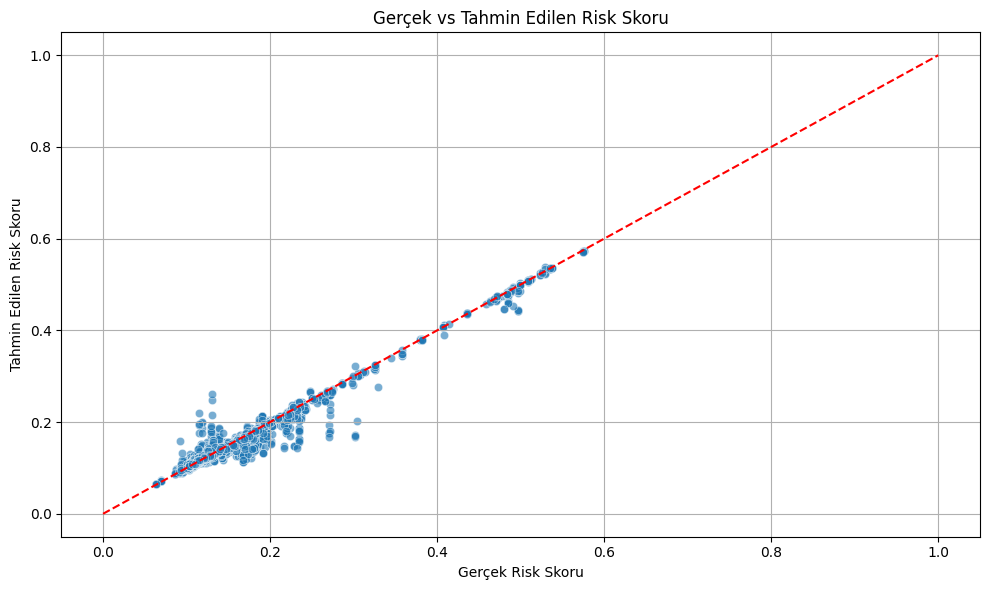

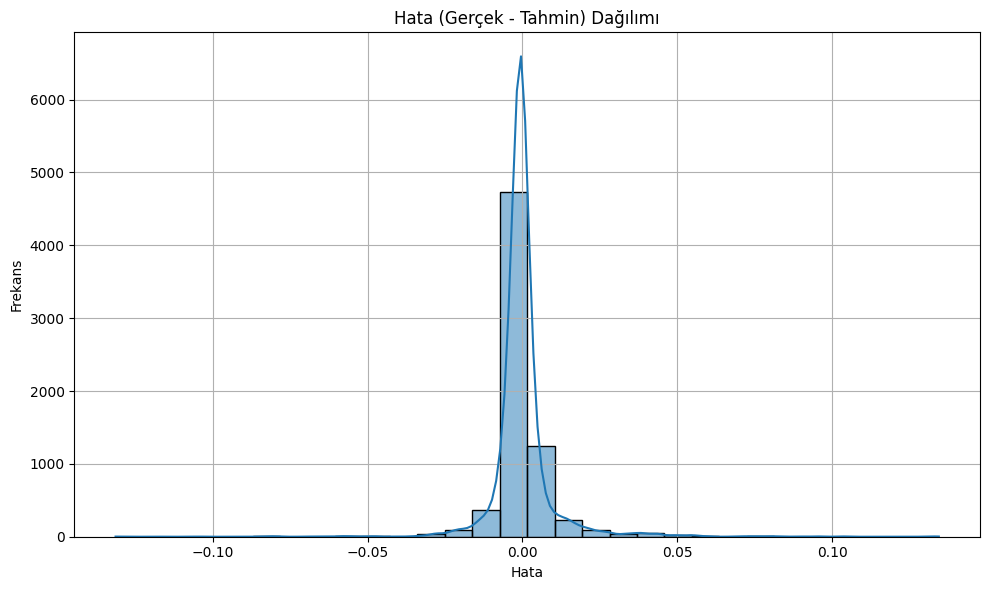

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7. Test Seti Üzerinde Tahmin ---
final_model = best_result[1]
y_pred = final_model.predict(X_test)

# --- 8. Değerlendirme Metrikleri ---
r2 = r2_score(y_test, y_pred)



print("\n--- Test Seti Performansı ---")
print(f"R² Skoru: {r2:.4f}")


# --- 9. Gerçek vs Tahmin Karşılaştırması ---
comparison_df = pd.DataFrame({
    "Gerçek Risk Skoru": y_test.values,
    "Tahmin Edilen Risk Skoru": y_pred
})

print("\n--- İlk 10 Karşılaştırma ---")
print(comparison_df.head(10))

# --- 10. Görselleştirme ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Gerçek Risk Skoru", y="Tahmin Edilen Risk Skoru", data=comparison_df, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')  # Doğrusal referans çizgisi
plt.title("Gerçek vs Tahmin Edilen Risk Skoru")
plt.xlabel("Gerçek Risk Skoru")
plt.ylabel("Tahmin Edilen Risk Skoru")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Hata Dağılımı ---
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title("Hata (Gerçek - Tahmin) Dağılımı")
plt.xlabel("Hata")
plt.ylabel("Frekans")
plt.grid(True)
plt.tight_layout()
plt.show()


PermutationExplainer explainer: 101it [00:36,  2.29it/s]


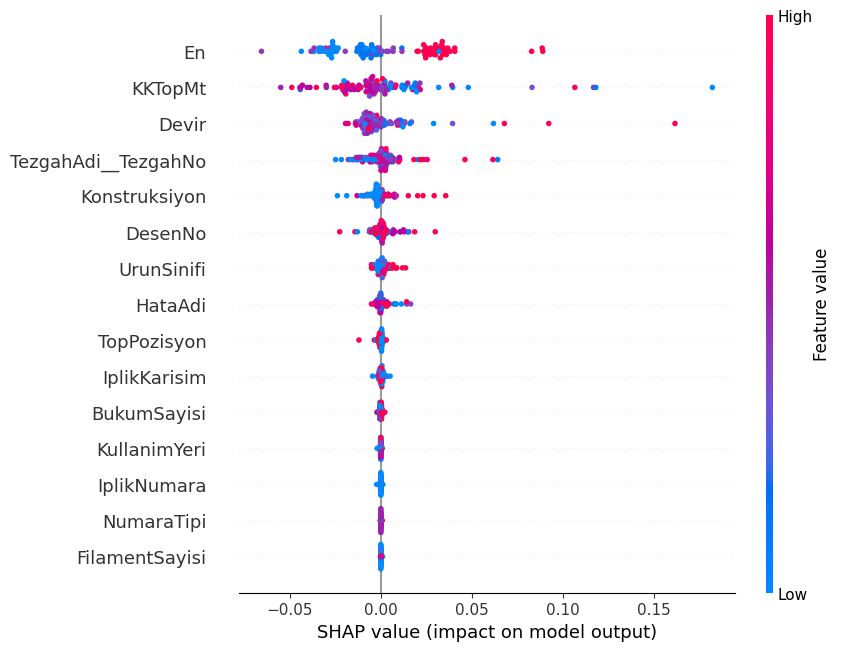

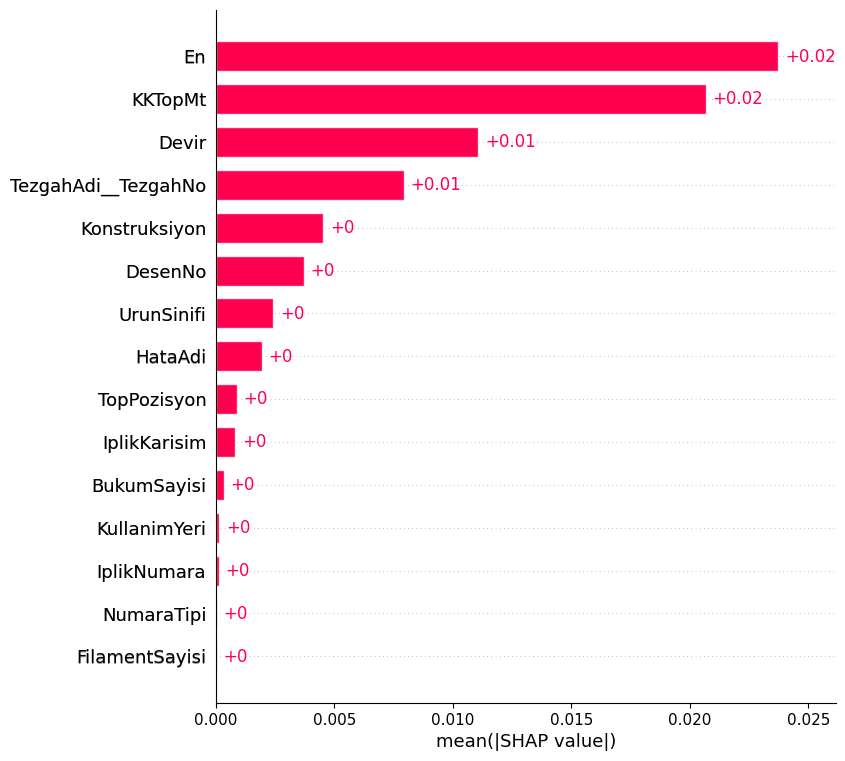

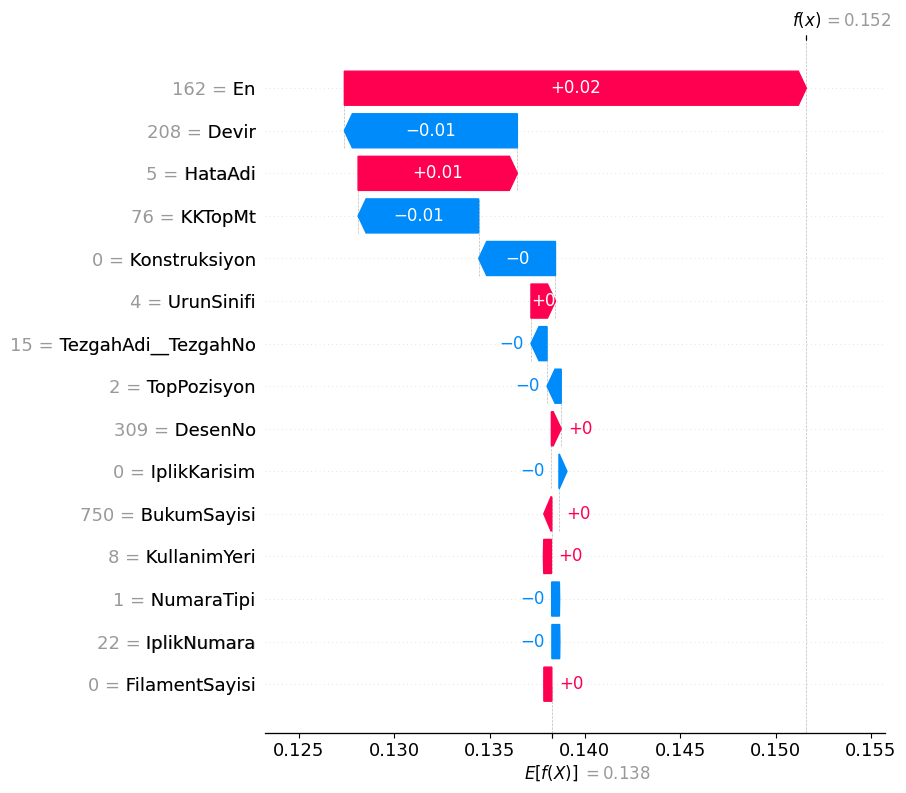

In [ ]:
import shap

# --- 1. En iyi modeli al ---
final_model = best_result[1]

# --- 2. SHAP değerlerini hesapla ---
explainer = None

# Modelin türüne göre uygun SHAP explainer seç
if isinstance(final_model, (RandomForestRegressor, GradientBoostingRegressor)):
    explainer = shap.Explainer(final_model.predict, X_test)
elif isinstance(final_model, XGBRegressor):
    explainer = shap.Explainer(final_model)
elif isinstance(final_model, LGBMRegressor):
    explainer = shap.Explainer(final_model)
else:
    raise ValueError("SHAP için desteklenmeyen model tipi")

# SHAP değerlerini hesapla
#shap_values = explainer(X_test)
shap_values = explainer(X_test.sample(100))

# --- 3. Önemli Özellikler Grafiği (Global) ---
shap.plots.beeswarm(shap_values, max_display=15)  # en önemli 15 özelliği göster

# --- 4. Özellik Önem Sıralaması ---
shap.plots.bar(shap_values, max_display=15)

# --- 5. Tek Bir Örnek için SHAP Değerleri (Local) ---
index = 0  # ilk örneği seç (değiştirilebilir)
shap.plots.waterfall(shap_values[index], max_display=15)


In [ ]:
import os
import json
import numpy as np
import pandas as pd

# LLM kullanmadan önce: pip install openai
import openai
from openai import OpenAI
client = OpenAI(api_key="OPENAI_API_KEY")

def top_shap_contributions(shap_values_row, feature_names, top_n=8):
    """Tek bir örnek için en büyük mutlak SHAP katkılarını döndürür."""
    vals = shap_values_row.values
    order = np.argsort(np.abs(vals))[::-1][:top_n]
    return [(feature_names[i], float(vals[i])) for i in order]

def llm_explain_risk(
    idx: int,
    shap_values,
    X_test: pd.DataFrame,
    model_pred,
    low_thr: float = 0.2,
    high_thr: float = 0.8,
    top_n: int = 8,
    model_name: str = None
):
    """
    index: test örneği index’i (X_test indeksine göre pozisyonel index değil -> iloc kullanacağız)
    shap_values: explainer(X_test) çıktısı
    model_pred: final_model.predict(X_test) çıktısı (numpy)
    low_thr/high_thr: düşük/yüksek risk eşikleri
    """
    # X_test indeksleri karışmasın diye pozisyonel erişim:
    # shap_values[i] sırası X_test.iloc[i] ile eşleşir.
    # idx parametresini pozisyon gibi kullanacağız.
    i = index

    pred = float(model_pred[i])
    feats = X_test.columns.tolist()
    top_contribs = top_shap_contributions(shap_values[i], feats, top_n=top_n)

    # Risk seviyesi belirleme
    if pred <= low_thr:
        level = "DÜŞÜK"
    elif pred >= high_thr:
        level = "YÜKSEK"
    else:
        level = "ORTA"

    # Prompt — domain terimlerine uygun kısa ve net
    prompt = f"""
Aşağıdaki üretim kaydı için 'risk_skoru' tahminini yorumla.
Model: {model_name or type(final_model).__name__}
Tahmin edilen risk_skoru: {pred:.4f} (Seviye: {level})
En etkili SHAP katkıları (özellik: katkı):
{json.dumps(top_contribs, ensure_ascii=False, indent=2)}

Kontekst:
- risk_skoru; DurusOrani, Sure ve TopMtFark bileşenleriyle ölçeklenmiş bir skor.
- Yüksek skor: operasyonel risk/dalgalanma ihtimali yüksek (duruş artışı, süre uzaması, metraj farkı…)
- Düşük skor: süreç istikrarlı ve risk düşük.

Görev:
1) Skor seviyesini (düşük/orta/yüksek) kısa bir cümleyle özetle.
2) SHAP katkılarına göre en güçlü 3 etkeni açıkla (kısa ve madde madde).
3) Operasyonel aksiyon öner: hız/devir, duruş önleme, iplik/tezgâh seçimi, planlama vb. 2–3 öneri.
4) Yalın, teknik ama sahaya yönelik yaz.
"""

    try:
        resp = client.chat.completions.create(
            model="gpt-4o-mini",  # elinizdeki modele göre değiştirin
            messages=[{"role":"user","content":prompt}],
            temperature=0.2,
            max_tokens=350
        )
        explanation = resp.choices[0].message.content
    except Exception as e:
        explanation = f"[LLM çağrısı başarısız] {e}"

    return {
        "idx": i,
        "risk_skoru": pred,
        "risk_seviyesi": level,
        "top_shap": top_contribs,
        "explanation": explanation
    }

# ÖRNEK KULLANIM
# Eşikler: veriniz 0–1 ölçeğinde; gerekirse medyan/çeyreklik temelli eşiklere de geçebilirsiniz.
llm_result = llm_explain_risk(
    idx=0,
    shap_values=shap_values,
    X_test=X_test,
    model_pred=y_pred,
    low_thr=0.25,
    high_thr=0.75,
    top_n=8,
    model_name=best_result[0]
)

print("\n--- LLM Açıklaması (Örnek 0) ---")
print(llm_result["explanation"])



--- LLM Açıklaması (Örnek 0) ---
1) Tahmin edilen risk skoru 0.1398 ile düşük seviyede bir risk olduğunu göstermektedir.

2) SHAP katkılarına göre en güçlü 3 etken:
   - **En**: Pozitif katkı sağlayarak risk skorunu artırıyor; bu, üretim sürecinin genel verimliliğini ve kalitesini olumlu etkileyen bir faktör.
   - **HataAdi**: Pozitif katkı ile risk skorunu artırıyor; hata türlerinin yönetimi ve çözümü, süreçteki istikrarı artırabilir.
   - **Devir**: Negatif katkı sağlıyor; devir oranının düşüklüğü, süreçteki verimliliğin artabileceğini ve dolayısıyla riskin azalabileceğini gösteriyor.

3) Operasyonel aksiyon önerileri:
   - **Hız ve Devir İyileştirmesi**: Üretim hızını artırarak ve devir oranını optimize ederek süreç verimliliğini artırmak.
   - **Duruş Önleme Stratejileri**: Duruş sürelerini minimize etmek için bakım planlamalarını gözden geçirerek önleyici bakım uygulamalarını artırmak.
   - **İplik ve Tezgâh Seçimi**: Üretim için en uygun iplik ve tezgâh kombinasyonlarını belirle

In [ ]:
# =======================
# Case-RAG: JSONL üretim
# =======================
import os, json, time, uuid
import numpy as np
import pandas as pd

from datetime import datetime
from typing import List, Dict, Any

import shap
# (Opsiyonel) LIME çok yavaş olabilir — örneklemle kullanın.
# from lime.lime_tabular import LimeTabularExplainer

from sklearn.base import BaseEstimator

# --------- LLM istemcisi ----------
from openai import OpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

# --------- 1) Yardımcılar ----------

def pick_top_indices_by_risk(y_pred: np.ndarray, top_k:int=100, high_thr:float=0.75):
    """Önce eşik üstü olanlar; yetmezse en yüksekten tamamla."""
    idx_high = np.where(y_pred >= high_thr)[0].tolist()
    if len(idx_high) >= top_k:
        return idx_high[:top_k]
    # tamamla
    rest = np.argsort(-y_pred).tolist()  # azalan
    seen = set(idx_high)
    for i in rest:
        if i not in seen:
            idx_high.append(i)
        if len(idx_high) == top_k:
            break
    return idx_high

def top_abs_shap(shap_row, feature_names:List[str], top_n:int=8):
    vals = np.array(shap_row.values if hasattr(shap_row, "values") else shap_row)
    order = np.argsort(np.abs(vals))[::-1][:top_n]
    return [(feature_names[i], float(vals[i])) for i in order]

# --------- 2) Rulebook motoru ----------

def load_rulebook(rulebook: List[Dict[str, Any]]):
    """Rulebook: [{'if':..., 'then':..., 'because':...}, ...]"""
    return rulebook

def rule_matches(row_dict: Dict[str, Any], rule_if: str) -> bool:
    """
    Güvenli, sınırlı bir eval: sadece row_dict'ı okur.
    Kural içinde ör: "IplikNumara in ['30/2','20/1'] and Devir>1100 and En>380"
    """
    allowed_names = set(row_dict.keys())
    # Hazırla
    local_env = {k: row_dict[k] for k in allowed_names}
    try:
        return bool(eval(rule_if, {"__builtins__": {}}, local_env))
    except Exception:
        return False

def apply_rulebook(row: pd.Series, rulebook: List[Dict[str,Any]]) -> List[Dict[str, str]]:
    rowd = row.to_dict()
    hits = []
    for r in rulebook:
        cond = r.get("if", "")
        if cond and rule_matches(rowd, cond):
            hits.append({
                "then": r.get("then",""),
                "because": r.get("because",""),
                "rule_if": cond
            })
    return hits

# --------- 3) SHAP (ve opsiyonel LIME) ----------

def compute_shap_subset(final_model: BaseEstimator, X: pd.DataFrame):
    """
    Ağaç tabanlı modeller için shap.Explainer genellikle TreeExplainer seçer.
    Çok büyük X'te örneklem alın.
    """
    explainer = shap.Explainer(final_model)
    return explainer(X)

# LIME (opsiyonel, ağır!)
# def compute_lime_subset(model: BaseEstimator, X: pd.DataFrame, train_sample: pd.DataFrame, top_features=8):
#     explainer = LimeTabularExplainer(
#         training_data=np.array(train_sample),
#         feature_names=train_sample.columns.tolist(),
#         mode='regression',
#         discretize_continuous=True
#     )
#     lime_res = []
#     for i in range(X.shape[0]):
#         exp = explainer.explain_instance(
#             data_row=X.iloc[i].values,
#             predict_fn=model.predict,
#             num_features=top_features
#         )
#         lime_res.append(exp.as_list())  # [(feat, contribution), ...]
#     return lime_res

# --------- 4) Prompt & LLM ----------

SYSTEM_PROMPT = (
    "You are a senior textile manufacturing engineer. "
    "Explain risks and actions concisely for loom operations. "
    "Keep Turkish concise, technical and field-oriented. Return JSON with keys: "
    "summary, root_cause_analysis, immediate_actions (list), long_term_actions (list), expected_outcome."
)

def build_prompt_line(risk: float, feats: Dict[str,Any], shap_top: List[tuple], rule_hits: List[Dict[str,str]]):
    level = "DÜŞÜK" if risk < 0.25 else ("YÜKSEK" if risk >= 0.75 else "ORTA")
    updown = []
    for f, v in shap_top[:4]:
        direction = "↑" if v>0 else "↓"
        updown.append(f"{f}({direction})")
    infl = ", ".join(updown) if updown else "—"
    # Context, insan-okunur prompt
    p = (
      f"Risk={level} ({risk:.2f}); "
      + ", ".join([f"{k}={v}" for k,v in feats.items()])
      + f". Influencers: {infl}. Açıkla ve aksiyon öner."
    )
    return p

def llm_completion(risk: float,
                   feats: Dict[str,Any],
                   shap_top: List[tuple],
                   rule_hits: List[Dict[str,str]],
                   model_name: str,
                   source_model: str):
    """
    LLM sadece explanation/aksiyon üretir. Biçim zorlamalı: JSON döndür.
    """
    user_prompt = {
        "purpose": "Üretim vakası için risk açıklaması ve aksiyon önerileri üret.",
        "model": model_name,
        "risk_score": round(float(risk), 4),
        "features": feats,
        "shap_top": [{"feature": f, "value": v} for f, v in shap_top],
        "rule_hits": rule_hits,
        "instructions": [
            "Türkçe yaz.",
            "Kısa ve sahaya yönelik anlat.",
            "Sadece şu JSON alanlarını döndür: summary, root_cause_analysis, immediate_actions (list), long_term_actions (list), expected_outcome.",
            "Sayısal değer uydurma, sadece verilenlerden çıkarım yap."
        ],
        "prompt_line": build_prompt_line(risk, feats, shap_top, rule_hits)
    }

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.2,
        messages=[
            {"role":"system","content": SYSTEM_PROMPT},
            {"role":"user","content": json.dumps(user_prompt, ensure_ascii=False)}
        ],
        max_tokens=450
    )
    content = resp.choices[0].message.content.strip()

    # Güvenlik: JSON bekliyoruz; bozulursa sarmalamaya çalışalım
    try:
        data = json.loads(content)
        # Beklenen anahtarlar:
        for k in ["summary","root_cause_analysis","immediate_actions","long_term_actions","expected_outcome"]:
            if k not in data:
                raise ValueError("Missing key")
        # tip düzeltmeleri
        if not isinstance(data.get("immediate_actions",[]), list):
            data["immediate_actions"] = [str(data["immediate_actions"])]
        if not isinstance(data.get("long_term_actions",[]), list):
            data["long_term_actions"] = [str(data["long_term_actions"])]
        return data, content
    except Exception:
        # JSON değilse tek alanlara sar
        return {
            "summary": content[:400],
            "root_cause_analysis": "",
            "immediate_actions": [],
            "long_term_actions": [],
            "expected_outcome": ""
        }, content

# --------- 5) Vaka kartı oluşturucu ----------

def make_case_card(row_meta: Dict[str,Any],
                   risk: float,
                   feats: Dict[str,Any],
                   shap_top: List[tuple],
                   rule_hits: List[Dict[str,str]],
                   llm_json: Dict[str,Any],
                   model_id: str,
                   equipment: str = None,
                   severity_policy = lambda r: "High" if r>=0.75 else ("Medium" if r>=0.4 else "Low")):

    # prompt (insan okunur satır)
    influencers = ", ".join([f"{f}({'↑' if v>0 else '↓'})" for f,v in shap_top[:4]]) if shap_top else "—"
    p = f"Risk={severity_policy(risk)} ({risk:.2f}); " + \
        ", ".join([f"{k}={v}" for k,v in feats.items()]) + \
        f". Influencers: {influencers}. What is the interpretation and actions?"

    card = {
        "id": row_meta.get("id", f"qa_{uuid.uuid4().hex[:6]}"),
        "prompt": p,
        "completion": {
            "summary": llm_json.get("summary",""),
            "root_cause_analysis": llm_json.get("root_cause_analysis",""),
            "immediate_actions": llm_json.get("immediate_actions",[]),
            "long_term_actions": llm_json.get("long_term_actions",[]),
            "expected_outcome": llm_json.get("expected_outcome","")
        },
        "context": {
            "risk_score": round(float(risk),4),
            "features": feats,
            "xai": {
                "shap_values": {f: v for f, v in shap_top[:8]}
            },
            "rule_hits": rule_hits,
            "source_model": model_id,
            "timestamp": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
        },
        "metadata": {
            "expert_verified": False,
            "severity": severity_policy(risk),
            "equipment": equipment or row_meta.get("Tezgah",""),
            "tags": list({ *[h.get('then','').split()[0] for h in rule_hits if h.get('then')],
                           *[f for f,_ in shap_top[:3]] })
        }
    }
    return card

# --------- 6) Toplu üretim ----------

def batch_generate_jsonl(
    df: pd.DataFrame,
    X: pd.DataFrame,
    final_model: BaseEstimator,
    y_pred: np.ndarray,
    rulebook: List[Dict[str,Any]],
    top_k: int = 100,
    jsonl_path: str = "case_cards.jsonl",
    id_prefix: str = "qa",
    equipment_col: str = "TezgahAdi__TezgahNo",
    feature_keys_for_prompt: List[str] = ("Devir","IplikNumara","En","KullanimYeri","DurusOrani"),
    model_id: str = "risk_model_v3"
):
    # En riskli örnekleri seç
    top_idx = pick_top_indices_by_risk(y_pred, top_k=top_k)

    X_sub = X.iloc[top_idx].copy()
    df_sub = df.iloc[top_idx].copy()

    # SHAP
    shap_vals = compute_shap_subset(final_model, X_sub)

    # (Opsiyonel) LIME: gerekirse buraya entegre edin (yavaş!)

    # JSONL yaz
    n_ok = 0
    with open(jsonl_path, "w", encoding="utf-8") as f:
        for i, ridx in enumerate(top_idx):
            # deterministik alanlar
            risk = float(y_pred[ridx])
            feats_for_prompt = {}
            for k in feature_keys_for_prompt:
                if k in df.columns:
                    feats_for_prompt[k] = df.iloc[ridx][k]

            shap_top = top_abs_shap(shap_vals[i], X_sub.columns.tolist(), top_n=8)

            # rules
            rule_hits = apply_rulebook(df.iloc[ridx], rulebook)

            # LLM açıklaması
            llm_json, raw_text = llm_completion(
                risk=risk,
                feats=feats_for_prompt,
                shap_top=shap_top,
                rule_hits=rule_hits,
                model_name=type(final_model).__name__,
                source_model=model_id
            )

            # kart
            row_meta = {
                "id": f"{id_prefix}_{str(i).zfill(4)}",
                "Tezgah": str(df.iloc[ridx].get(equipment_col, "")),
            }
            card = make_case_card(
                row_meta=row_meta,
                risk=risk,
                feats=feats_for_prompt,
                shap_top=shap_top,
                rule_hits=rule_hits,
                llm_json=llm_json,
                model_id=model_id,
                equipment=str(df.iloc[ridx].get(equipment_col, ""))
            )

            f.write(json.dumps(card, ensure_ascii=False) + "\n")
            n_ok += 1

    return {"written": n_ok, "path": jsonl_path}

# final_model = best_result[1]
# y_pred = final_model.predict(X_test)

# Örnek rulebook (seninkini ver)
rulebook = [
 {"if":"IplikNumara in ['30/2','20/1'] and Devir>1100 and En>380",
  "then":"durus_orani ↑ , kalite ↓",
  "because":"yüksek hız + geniş en → atkı kopuş riski"},
 {"if":"durus_orani > 0.10",
  "then":"risk_skoru ↑",
  "because":"%10 üzeri duruş oranı kaliteyi negatif etkiler"},
 # ... (devamını ekle)
]

out = batch_generate_jsonl(
    df=df.loc[X_test.index],         # testteki satırların ham özellikleri
    X=X_test,                         # model girdisi
    final_model=final_model,
    y_pred=y_pred,
    rulebook=rulebook,
    top_k=100,                        # en riskli 100 vaka
    jsonl_path="case_cards.jsonl",
    feature_keys_for_prompt=["Devir","IplikNumara","En","Karisim","DurusOrani"],
    model_id="risk_model_v3"
)
print(out)
